In [349]:
import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import _get_inverse_affine_matrix, affine

In [350]:
center = [0,0]
angle = -45
translate = [0,0]
scale = 1
shear = [0,0]
inverted = False

mat = _get_inverse_affine_matrix(center,angle,translate,scale,shear,inverted)
new_mat = np.array([mat[:3],mat[3:],[0,0,1]],dtype=np.float32)
new_mat

array([[ 0.70710677,  0.70710677,  0.        ],
       [-0.70710677,  0.70710677,  0.        ],
       [ 0.        ,  0.        ,  1.        ]], dtype=float32)

In [351]:
# center=[150,200]
# width=400
# height=300

# center_f = [1.0 * (c - s * 0.5) for c, s in zip(center, [width, height])]
# center_f

In [352]:
training_img = "009920"
dataset_root = "/mnt/c/Users/vlade813/Desktop/School/Masters/Spring_2023/Deep_Learning/VOCdatasets/VOC2007"
img_pth = os.path.join(dataset_root,"JPEGImages/009920.jpg")
annotation = os.path.join(dataset_root,"Annotations/009920.xml")

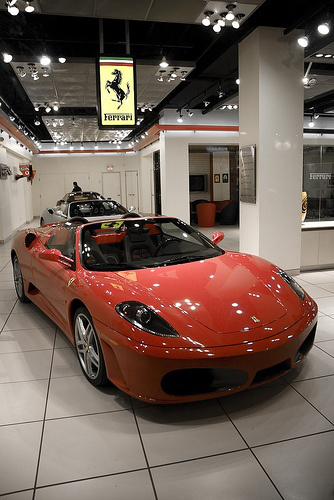

In [353]:
from PIL import Image
img = Image.open(img_pth)
img

In [354]:
with open(annotation,'r') as f:
    string = f.read()
    string = string.split("<bndbox>")
    string = string[1].split("</bndbox>")[0]
    
    x1 = int(string.split("<xmin>")[1].split("</xmin>")[0])
    y1 = int(string.split("<ymin>")[1].split("</ymin>")[0])
    x2 = int(string.split("<xmax>")[1].split("</xmax>")[0])
    y2 = int(string.split("<ymax>")[1].split("</ymax>")[0])
    
    ann_bbox = np.array([x1,y1,x2,y2])
    print([x1,y1,x2,y2])

[9, 213, 321, 419]


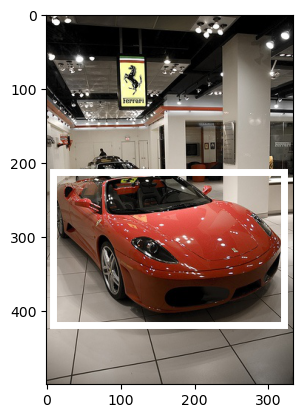

In [355]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=5, edgecolor='w', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

In [356]:
def augment_bbox(bbox,transform_mat,return_aug_polygon=False):
    # augment_bbox() can take in bbox OR coords
    #  - for augmenting a bbox, use bbox
    #  - for inverting an augmented bbox, use coords
    
    # augment bbox
    # - - - - - - 
    
    if bbox.shape == (4,):
        # augment the bbox
        x1,y1,x2,y2 = bbox
        upper_left  = np.asarray([x1,y1,1],dtype=np.float32)
        upper_right = np.asarray([x2,y1,1],dtype=np.float32)
        lower_left  = np.asarray([x1,y2,1],dtype=np.float32)
        lower_right = np.asarray([x2,y2,1],dtype=np.float32)
    elif bbox.shape == (5,2) or bbox.shape == (4,2):
        # reverse the bbox's augmentation
        # bbox is [ul, ur, lr, ll, ul] or missing last "ul"
        upper_left  = np.asarray(np.append(bbox[0],1),dtype=np.float32)
        upper_right = np.asarray(np.append(bbox[1],1),dtype=np.float32)
        lower_right = np.asarray(np.append(bbox[2],1),dtype=np.float32)
        lower_left  = np.asarray(np.append(bbox[3],1),dtype=np.float32)
    else:
        raise Exception("bbox shape is not compatible", bbox.shape)
    
    # print(upper_left, upper_left.shape, bbox[0])
    new_ul = np.matmul(transform_mat,upper_left)[:2]
    new_ur = np.matmul(transform_mat,upper_right)[:2]
    new_ll = np.matmul(transform_mat,lower_left)[:2]
    new_lr = np.matmul(transform_mat,lower_right)[:2]
    
    coords = [new_ul, new_ur, new_lr, new_ll]
    five_coords = coords + [new_ul] # append for closer loop
    # xs,ys = zip(*five_coords)
    # new_coords = 

    # create surrounding bbox
    # - - - - - - - - - - - -
    npcoords = np.asarray(five_coords,dtype=np.float32)
    all_x_coords = npcoords[:,0]
    all_y_coords = npcoords[:,1]
    
    full_x1 = np.min(all_x_coords)
    full_x2 = np.max(all_x_coords)
    full_y1 = np.min(all_y_coords)
    full_y2 = np.max(all_y_coords)
    
    aug_bbox = np.asarray([full_x1, full_y1, full_x2, full_y2], dtype=np.float32)
    
    if return_aug_polygon:
        return aug_bbox,npcoords
    
    return aug_bbox

def get_plottable_coords(bbox):
    # turns a x1,y1,x2,y2 bbox into 4 coordinates (plus the original point)
    x1,y1,x2,y2 = bbox
    
    ul = np.asarray([x1,y1],dtype=np.float32)
    ur = np.asarray([x2,y1],dtype=np.float32)
    ll = np.asarray([x1,y2],dtype=np.float32)
    lr = np.asarray([x2,y2],dtype=np.float32)
    
    coords = [ul, ur, lr, ll]
    five_coords = coords + [ul] # append for closer loop
    xs,ys = zip(*five_coords)
    
    return xs,ys
    

(334, 500)
(334, 500)


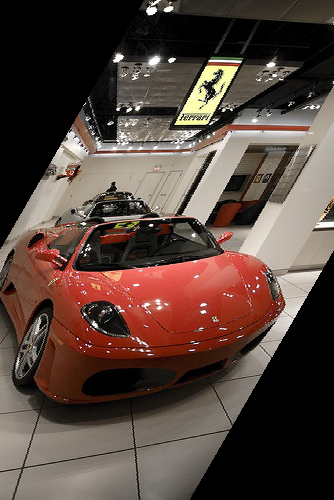

In [357]:
center    = [img.size[0]/2,img.size[1]/2]
angle     = 0
translate = [0,0]
scale     = 1
shear     = [30,0]
inverted  = False

aug_im = affine(img,angle,translate,scale,shear,center=center)
print(img.size)
print(aug_im.size)
aug_im

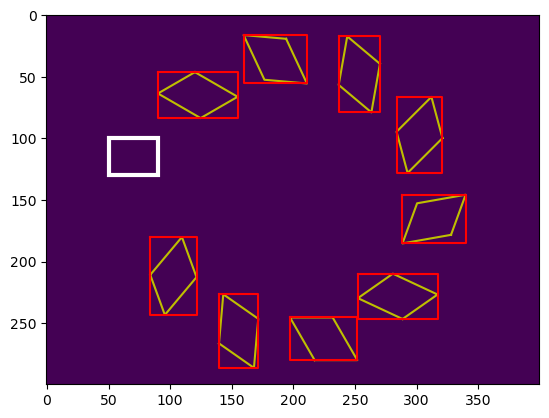

In [358]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
bbox = np.array([50,100,90,130])
x1,y1,x2,y2 = bbox
im = np.zeros((300,400))
center = [400/2,300/2]
ax.imshow(im)

# shear_upp = 60
for angle in range(30,330,35):
# for shear in zip(range(-shear_upp,shear_upp,10),[0]*len(range(-shear_upp,shear_upp,10))):
    # print(shear)
    mat = _get_inverse_affine_matrix(center,angle,translate,scale,shear,inverted)
    new_mat = np.array([mat[:3],mat[3:],[0,0,1]],dtype=np.float32)
    
    aug_bbox,coords = augment_bbox(bbox,new_mat,return_aug_polygon=True)
    full_xs,full_ys = get_plottable_coords(aug_bbox)
    
    # plot the augmented bbox
    xs,ys = zip(*coords)
    ax.plot(xs,ys,'y')
    
    # plot the surrounding bbox
    ax.plot(full_xs,full_ys,'r')

# Create a Rectangle patch
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='w', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

[[ 81.440094 112.11418 ]
 [302.0574   332.7315  ]
 [156.3934   478.3955  ]
 [-64.22392  257.77817 ]
 [ 81.440094 112.11418 ]] (5, 2)
[  9 213 321 419] (4,)


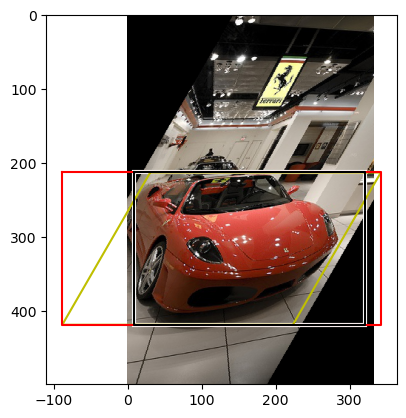

In [359]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(aug_im)

center    = [aug_im.size[0]/2,aug_im.size[1]/2]
angle     = 0
translate = [0,0]
scale     = 1
shear     = [30,0]
inverted  = False

mat     = _get_inverse_affine_matrix(center,angle,translate,scale,shear,inverted)
new_mat = np.array([mat[:3],mat[3:],[0,0,1]],dtype=np.float32)
aug_bbox, coords = augment_bbox(ann_bbox,new_mat,return_aug_polygon=True)
full_xs,full_ys = get_plottable_coords(aug_bbox)

# augment_bbox() can take in bbox OR coords
#  - for augmenting a bbox, use bbox
#  - for inverting an augmented bbox, use coords

angle= -45
inv_mat     = _get_inverse_affine_matrix(center,angle,translate,scale,shear,inverted=True)
inv_new_mat = np.array([inv_mat[:3],inv_mat[3:],[0,0,1]],dtype=np.float32)
inv_aug_bbox, inv_coords = augment_bbox(np.array(coords),inv_new_mat,return_aug_polygon=True)
inv_full_xs, inv_full_ys = get_plottable_coords(inv_aug_bbox)

print(aug_xs_ys,aug_xs_ys.shape)
print(ann_bbox,ann_bbox.shape)

# plot the augmented bbox
xs,ys = zip(*coords)
ax.plot(xs,ys,'y')

# plot the surrounding bbox
ax.plot(full_xs,full_ys,'r')

# Create a Rectangle patch
x1,y1,x2,y2 = ann_bbox
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='w', facecolor='none')

# plot the inverted bounding box
xs,ys = zip(*inv_coords)
ax.plot(inv_xs, inv_ys, 'k')

# Add the patch to the Axes
ax.add_patch(rect)

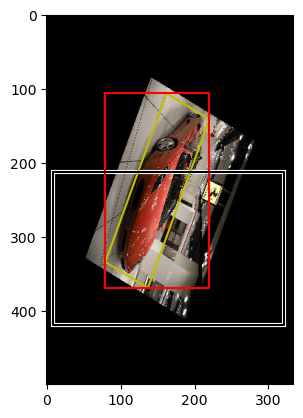

In [360]:
# Create figure and axes
fig, ax = plt.subplots()


center    = [img.size[0]/2,img.size[1]/2]
angle     = 60
translate = [0.5,0.5]
scale     = 0.5
shear     = [30,-50]

aug_im = affine(img,angle,translate,scale,shear,center=center)

# Display the image
ax.imshow(aug_im)


mat     = _get_inverse_affine_matrix(center,angle,translate,scale,shear,inverted=False)
new_mat = np.array([mat[:3],mat[3:],[0,0,1]],dtype=np.float32)
aug_bbox, coords = augment_bbox(ann_bbox,new_mat,return_aug_polygon=True)
full_xs,full_ys = get_plottable_coords(aug_bbox)

# augment_bbox() can take in bbox OR coords
#  - for augmenting a bbox, use bbox
#  - for inverting an augmented bbox, use coords

inv_mat     = _get_inverse_affine_matrix(center,angle,translate,scale,shear,inverted=True)
inv_new_mat = np.array([inv_mat[:3],inv_mat[3:],[0,0,1]],dtype=np.float32)
inv_aug_bbox, inv_coords = augment_bbox(np.array(coords),inv_new_mat,return_aug_polygon=True)
inv_full_xs, inv_full_ys = get_plottable_coords(inv_aug_bbox)

# plot the augmented bbox
xs,ys = zip(*coords)
ax.plot(xs,ys,'y')

# plot the surrounding bbox
ax.plot(full_xs,full_ys,'r')

# Create a Rectangle patch
x1,y1,x2,y2 = ann_bbox
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='w', facecolor='none')

# plot the inverted bounding box
inv_xs, inv_ys = zip(*inv_coords)
ax.plot(inv_xs, inv_ys, 'k')

# Add the patch to the Axes
ax.add_patch(rect)

In [361]:
mat

[-0.266044443118978,
 -0.27941187104107323,
 281.78238976113767,
 0.7309511000407718,
 -0.1720148143729926,
 171.43486988643926]

In [362]:
inv_mat

[-0.6880592574919704,
 1.117647484164293,
 2.2792308467496127,
 -2.923804400163087,
 -1.064177772475912,
 1006.3137690325332]